In [10]:
# Imports here

import os

import numpy as np

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets, transforms, models

from collections import OrderedDict # https://docs.python.org/3/library/collections.html

import json

import time

from PIL import Image   # https://pillow.readthedocs.io/en/stable/


# Cats vs Dogs vs Horses

This notebook based on
https://colab.research.google.com/drive/17beV6noWSi4vohmDI1-liG9WKLYm4jtX?usp=sharing



In [ ]:
# # keep the session allve
# while True:pass

In [12]:
from datetime import datetime

In [13]:
import datetime
import pytz
israel_tz = pytz.timezone('Asia/Jerusalem')

get data from git repo

In [14]:
# %rm -rf dogs_and_cats_classifier_project
!git clone https://github.com/YamElgabsi/dogs_and_cats_classifier_project

Cloning into 'dogs_and_cats_classifier_project'...
remote: Enumerating objects: 1657, done.
remote: Counting objects: 100% (357/357), done.
remote: Compressing objects: 100% (346/346), done.
remote: Total 1657 (delta 11), reused 348 (delta 8), pack-reused 1300
Receiving objects: 100% (1657/1657), 98.50 MiB | 28.83 MiB/s, done.
Resolving deltas: 100% (27/27), done.


In [15]:
project_dir = '/content/dogs_and_cats_classifier_project'
data_dir = project_dir+ '/data_animals/animals'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

number_classes = 3

In [16]:
degrees_rotation = 30
size_crop = 224
size_resize = 256
normalize_mean = [0.485, 0.456, 0.406]
normalize_std = [0.229, 0.224, 0.225]
batch_size = 32

train_transforms = transforms.Compose([transforms.RandomRotation(degrees_rotation),
                                       transforms.RandomResizedCrop(size_crop),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize(normalize_mean, normalize_std)
                                      ])

valid_transforms = transforms.Compose([transforms.Resize(size_resize), 
                                       transforms.CenterCrop(size_crop),
                                       transforms.ToTensor(),
                                       transforms.Normalize(normalize_mean, normalize_std)
                                      ])

test_transforms = transforms.Compose([transforms.Resize(size_resize),
                                      transforms.CenterCrop(size_crop),
                                      transforms.ToTensor(),
                                      transforms.Normalize(normalize_mean, normalize_std)
                                     ])

train_data = datasets.ImageFolder(train_dir, transform = train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform = valid_transforms)
test_data = datasets.ImageFolder(test_dir, transform = test_transforms)

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size)


### Label mapping

In [17]:
with open(data_dir+'/cat_to_name.json', 'r') as f:
    category_label_to_name = json.load(f)
    print(category_label_to_name)

{'1': 'dog', '2': 'cat', '3': 'horse'}


# Building and training the classifier

In [ ]:
model = models.vgg16(pretrained = True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

dropout_probability = 0.5
in_features = 25088
out_features = 1024

classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(in_features, out_features)),
                                        ('drop', nn.Dropout(p = dropout_probability)),
                                        ('relu', nn.ReLU()),
                                        ('fc2', nn.Linear(out_features, number_classes)),
                                        ('output', nn.LogSoftmax(dim = 1))
                                       ]))
    
model.classifier = classifier

In [19]:
# Train the network

# Use GPU if it's available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.NLLLoss()
learning_rate = 0.001

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr = learning_rate)

model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [20]:
# Train the network

# Use GPU if it's available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.NLLLoss()
learning_rate = 0.001

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr = learning_rate)

model.to(device)

epochs = 10 #10
validation_step = True

print('Training started')
start_training_time = time.time()

for epoch in range(epochs):
    train_loss = 0
    for inputs, labels in train_loader:     
        
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        log_probabilities = model.forward(inputs)
        loss = criterion(log_probabilities, labels)
        loss.backward()
        optimizer.step()

        train_loss = train_loss + loss.item()
    
    print('\nEpoch: {}/{} '.format(epoch + 1, epochs),
          '\n    Training:\n      Loss: {:.4f}  '.format(train_loss / len(train_loader))
         )
           
    if validation_step == True:
        
        valid_loss = 0
        valid_accuracy = 0
        model.eval()

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                log_probabilities = model.forward(inputs)
                loss = criterion(log_probabilities, labels)
        
                valid_loss = valid_loss + loss.item()
        
                # Calculate accuracy
                probabilities = torch.exp(log_probabilities)
                top_probability, top_class = probabilities.topk(1, dim = 1)
                
                equals = top_class == labels.view(*top_class.shape)
                
                valid_accuracy = valid_accuracy + torch.mean(equals.type(torch.FloatTensor)).item()
        
        model.train()
       
        print("\n    Validation:\n      Loss: {:.4f}  ".format(valid_loss / len(valid_loader)),
              "Accuracy: {:.4f}".format(valid_accuracy / len(valid_loader)))
        
end_training_time = time.time()
print('Training ended')

training_time = end_training_time - start_training_time
print('\nTraining time: {:.0f}m {:.0f}s'.format(training_time / 60, training_time % 60))

Training started

Epoch: 1/10  
    Training:
      Loss: 1.3001  

    Validation:
      Loss: 0.2585   Accuracy: 0.9554

Epoch: 2/10  
    Training:
      Loss: 0.2787  

    Validation:
      Loss: 0.2290   Accuracy: 0.9554

Epoch: 3/10  
    Training:
      Loss: 0.2119  

    Validation:
      Loss: 0.3987   Accuracy: 0.9330

Epoch: 4/10  
    Training:
      Loss: 0.1932  

    Validation:
      Loss: 0.4080   Accuracy: 0.9375

Epoch: 5/10  
    Training:
      Loss: 0.1796  

    Validation:
      Loss: 0.1915   Accuracy: 0.9688

Epoch: 6/10  
    Training:
      Loss: 0.1883  

    Validation:
      Loss: 0.2728   Accuracy: 0.9554

Epoch: 7/10  
    Training:
      Loss: 0.1770  

    Validation:
      Loss: 0.4047   Accuracy: 0.8953

Epoch: 8/10  
    Training:
      Loss: 0.1620  

    Validation:
      Loss: 0.2446   Accuracy: 0.9598

Epoch: 9/10  
    Training:
      Loss: 0.2030  

    Validation:
      Loss: 0.2106   Accuracy: 0.9643

Epoch: 10/10  
    Training:
      Lo

## Testing your network


In [31]:
test_loss = 0
test_accuracy = 0
model.eval()


print('Validation started')
start_time = time.time()

for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    log_probabilities = model.forward(inputs)
    loss = criterion(log_probabilities, labels)

    test_loss = test_loss + loss.item()

    # Calculate accuracy
    probabilities = torch.exp(log_probabilities)
    top_probability, top_class = probabilities.topk(1, dim = 1)

    equals = top_class == labels.view(*top_class.shape)

    test_accuracy = test_accuracy + torch.mean(equals.type(torch.FloatTensor)).item()

end_time = time.time()
print('Validation ended')
validation_time = end_time - start_time
print('Validation time: {:.0f}m {:.0f}s'.format(validation_time / 60, validation_time % 60))

print("\nTest:\n  Loss: {:.4f}  ".format(test_loss / len(test_loader)),
      "Accuracy: {:.4f}".format(test_accuracy / len(test_loader)))

Validation started
Validation ended
Validation time: 0m 3s

Test:
  Loss: 0.0885   Accuracy: 0.9883


## Save the checkpoint

In [22]:
model.class_to_idx = train_data.class_to_idx

checkpoint = {'network': 'vgg16',
              'input_size': in_features,
              'output_size': number_classes,
              'learning_rate': learning_rate,       
              'batch_size': batch_size,
              'classifier' : classifier,
              'epochs': epochs,
              'optimizer': optimizer.state_dict(),
              'state_dict': model.state_dict(),
              'class_to_idx': model.class_to_idx}

# Get the current datetime in the Israel timezone
now_israel = datetime.datetime.now(israel_tz)

# Format the datetime as a string in the desired format
date_time_str = now_israel.strftime('%Y-%m-%d %H:%M')
path_to_checkpoint = project_dir+f'/checkpoint_{date_time_str}.pth'
torch.save(checkpoint,path_to_checkpoint )

In [23]:
def load_checkpoint(file_path):
    checkpoint = torch.load(file_path)
    learning_rate = checkpoint['learning_rate']
    model = getattr(torchvision.models, checkpoint['network'])(pretrained=True)
    model.classifier = checkpoint['classifier']
    model.epochs = checkpoint['epochs']
    model.optimizer = checkpoint['optimizer']
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']

    return model

model = load_checkpoint(path_to_checkpoint)

## Image Preprocessing



In [24]:
def process_image(pil_image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    img_loader = transforms.Compose([transforms.Resize(size_resize),
                                     transforms.CenterCrop(size_crop), 
                                     transforms.ToTensor()])
    
    #pil_image = Image.open(image)
    pil_image = img_loader(pil_image).float()
    
    np_image = np.array(pil_image)    
    
    mean = np.array(normalize_mean)
    std = np.array(normalize_std)
    np_image = (np.transpose(np_image, (1, 2, 0)) - mean) / std    
    np_image = np.transpose(np_image, (2, 0, 1))
            
    return np_image

In [25]:
def imshow(np_image, ax = None, title = None):
    if ax is None:
        fig, ax = plt.subplots()

    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    np_image = np.transpose(np_image, (1, 2, 0))

    # Undo preprocessing
    mean = np.array(normalize_mean)
    std = np.array(normalize_std)
    np_image = std * np_image + mean

    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    np_image = np.clip(np_image, 0, 1)

    ax.imshow(np_image)

    return ax

In [26]:
def predict(pil_image, model, top_k_probabilities=3):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    # Use GPU if it's available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)
    model.eval()

    np_image = process_image(pil_image)
    tensor_image = torch.from_numpy(np_image)

    inputs = Variable(tensor_image.float())

    if torch.cuda.is_available():
        inputs = Variable(tensor_image.float().cuda())

    inputs = inputs.unsqueeze(dim=0)
    log_probabilities = model.forward(inputs)
    probabilities = torch.exp(log_probabilities)

    top_probabilities, top_classes = probabilities.topk(top_k_probabilities, dim=1)
    class_to_idx_inverted = {model.class_to_idx[c]: c for c in model.class_to_idx}
    top_mapped_classes = list()

    for label in top_classes.cpu().detach().numpy()[0]:
        top_mapped_classes.append(class_to_idx_inverted[label])

    return top_probabilities.cpu().detach().numpy()[0], top_mapped_classes

## Sanity Checking

In [27]:
print(model.class_to_idx)


{'1': 0, '2': 1, '3': 2}


/content/dogs_and_cats_classifier_project/data_animals/animals/test_random/1.jpg


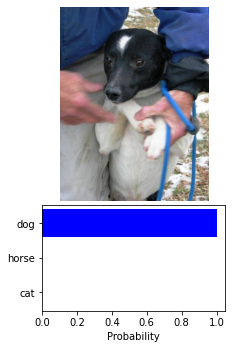

/content/dogs_and_cats_classifier_project/data_animals/animals/test_random/2.jpg


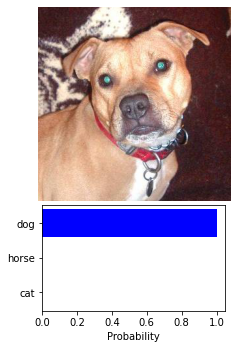

/content/dogs_and_cats_classifier_project/data_animals/animals/test_random/3.jpg


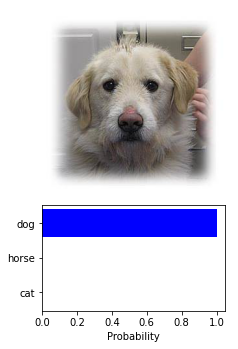

/content/dogs_and_cats_classifier_project/data_animals/animals/test_random/4.jpg


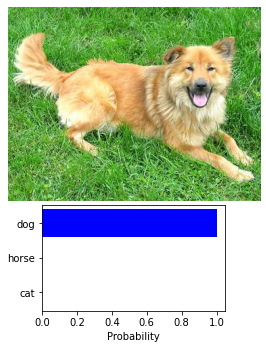

/content/dogs_and_cats_classifier_project/data_animals/animals/test_random/5.jpg


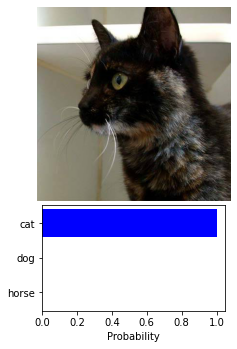

/content/dogs_and_cats_classifier_project/data_animals/animals/test_random/6.jpg


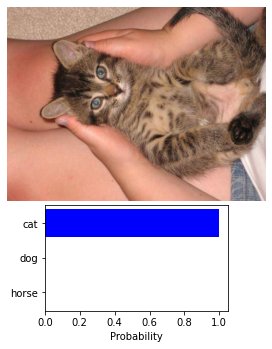

/content/dogs_and_cats_classifier_project/data_animals/animals/test_random/7.jpg


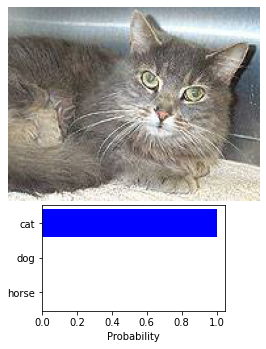

/content/dogs_and_cats_classifier_project/data_animals/animals/test_random/8.jpg


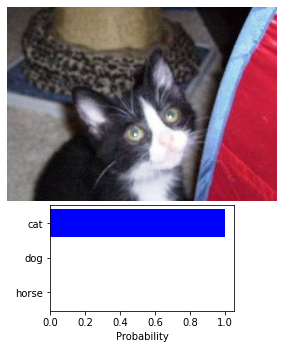

/content/dogs_and_cats_classifier_project/data_animals/animals/test_random/9.jpg


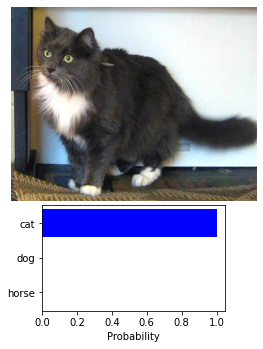

/content/dogs_and_cats_classifier_project/data_animals/animals/test_random/10.jpg


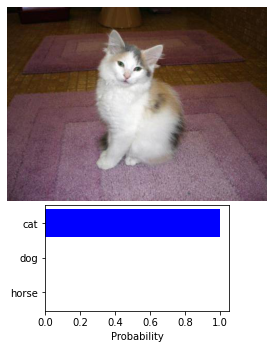

/content/dogs_and_cats_classifier_project/data_animals/animals/test_random/11.jpg


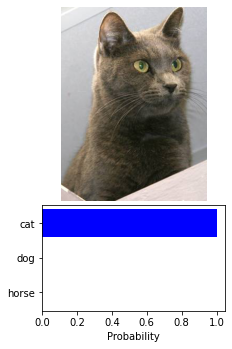

/content/dogs_and_cats_classifier_project/data_animals/animals/test_random/12.jpg


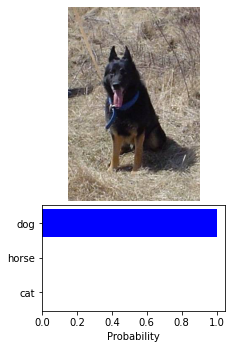

/content/dogs_and_cats_classifier_project/data_animals/animals/test_random/13.jpg


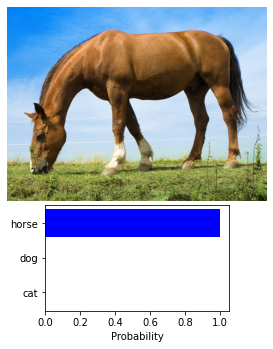

/content/dogs_and_cats_classifier_project/data_animals/animals/test_random/14.jpg


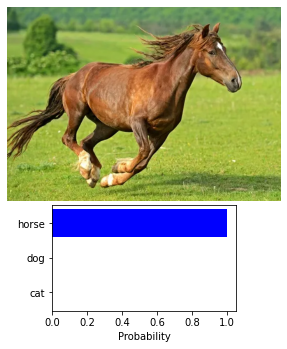

/content/dogs_and_cats_classifier_project/data_animals/animals/test_random/15.jpg


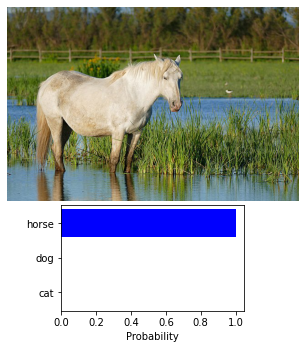

/content/dogs_and_cats_classifier_project/data_animals/animals/test_random/16.jpg


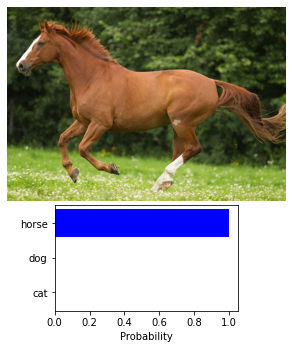

/content/dogs_and_cats_classifier_project/data_animals/animals/test_random/17.jpg


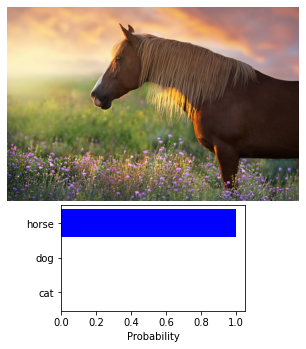

/content/dogs_and_cats_classifier_project/data_animals/animals/test_random/18.jpg


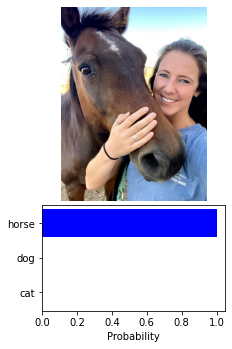

In [28]:
test_case = 18

for i in range(1,test_case+1):
    image_path = '/content/dogs_and_cats_classifier_project/data_animals/animals/test_random/'+str(i)+'.jpg'
    print(image_path)

    pil_image = Image.open(image_path)
    top_probabilities, top_classes = predict(pil_image, model, top_k_probabilities=3)
    max_index = np.argmax(top_probabilities)
    max_probability = top_probabilities[max_index]
    label = top_classes[max_index]

    fig = plt.figure(figsize=(6,6))
    ax1 = plt.subplot2grid((15,9), (0,0), colspan = 9, rowspan = 9)
    ax2 = plt.subplot2grid((15,9), (9,2), colspan = 5, rowspan = 5)

    ax1.axis('off')
    ax1.imshow(pil_image)

    labels = []
    for c in top_classes:
        labels.append(category_label_to_name[c])

    y_pos = np.arange(3)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(labels)
    ax2.set_xlabel('Probability')
    ax2.invert_yaxis()
    ax2.barh(y_pos, top_probabilities, xerr = 0, align = 'center', color = 'blue')

    plt.show()